In [ ]:
from torchkeras.tabular import TabularPreprocessor
from datetime import datetime
import pandas as pd

dataset_version = 200
ckpt_path = f'/home/hwxu/Projects/Competition/Telecom/Output/ckpt/retrain_ft_transformer_{datetime.now()}.ckpt'
train_data = pd.read_csv(
    f'/home/hwxu/Projects/Competition/Telecom/Input/processed/train{dataset_version}.csv')
validation_data = pd.read_csv(
    f'/home/hwxu/Projects/Competition/Telecom/Input/processed/val{dataset_version}.csv')

In [ ]:
from sklearn.model_selection import train_test_split

dftrain_raw, dfval_raw = train_test_split(
    train_data, random_state=42, test_size=0.2)

In [9]:
from torchkeras.tabular import TabularDataset
from torch.utils.data import DataLoader

target_col = 'is_sa'
numeric_cols = validation_data.select_dtypes(
    include=['float64', 'int64']).columns.tolist()
cat_cols = validation_data.select_dtypes(include=['object']).columns.tolist()

pipe = TabularPreprocessor(cat_features=cat_cols,
                           numeric_features=numeric_cols)

dffull = pipe.fit_transform(train_data.drop(
    target_col, axis=1)).join(train_data[target_col])
dftrain = pipe.fit_transform(dftrain_raw.drop(
    target_col, axis=1)).join(train_data[target_col])
dfval = pipe.transform(dfval_raw.drop(target_col, axis=1)
                       ).join(train_data[target_col])
dftest = pipe.transform(validation_data)

In [10]:
def get_dataset(dfdata):
    return TabularDataset(
        data=dfdata,
        task='classification',
        target=[target_col],
        continuous_cols=pipe.get_numeric_features(),
        categorical_cols=pipe.get_embedding_features()
    )


def get_dataloader(ds, batch_size=1024, num_workers=0, shuffle=False):
    dl = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=False,
    )
    return dl


ds_full = get_dataset(dffull)
ds_train = get_dataset(dftrain)
ds_val = get_dataset(dfval)
ds_test = TabularDataset(dftest, task='classification', continuous_cols=pipe.get_numeric_features(
), categorical_cols=pipe.get_embedding_features())

dl_full = get_dataloader(ds_full, shuffle=True)
dl_train = get_dataloader(ds_train, shuffle=True)
dl_val = get_dataloader(ds_val, shuffle=False)
dl_test = get_dataloader(ds_test, shuffle=False)

In [11]:
from torchkeras.tabular.models import FTTransformerConfig, FTTransformerModel

model_config = FTTransformerConfig(
    task="classification",
    num_attn_blocks=3
)

config = model_config.merge_dataset_config(ds_train)
net = FTTransformerModel(config=config)

# 初始化参数
net.reset_weights()
net.data_aware_initialization(dl_train)

print(net.backbone.output_dim)
print(net.hparams.output_dim)

32
2


In [12]:
from torchkeras import KerasModel
from torchkeras.tabular import StepRunner
import torch
from torch import nn

KerasModel.StepRunner = StepRunner


class BinaryF1Score(nn.Module):
    def __init__(self):
        super().__init__()

        self.tp = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.fp = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.tn = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.fn = nn.Parameter(torch.tensor(0.0), requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.argmax(dim=-1)
        targets = targets.reshape(-1)
        tp = ((preds == 1) & (targets == 1)).sum()
        fp = ((preds == 1) & (targets == 0)).sum()
        tn = ((preds == 0) & (targets == 0)).sum()
        fn = ((preds == 0) & (targets == 1)).sum()
        self.tp += tp
        self.fp += fp
        self.tn += tn
        self.fn += fn
        # return f1
        return 2 * tp.float() / (2 * tp + fp + fn).float()

    def compute(self):
        precision = self.tp.float() / (self.tp + self.fp).float()
        recall = self.tp.float() / (self.tp + self.fn).float()
        f1 = 2 * precision * recall / (precision + recall)
        return f1

    def reset(self):
        self.tp -= self.tp
        self.fp -= self.fp
        self.tn -= self.tn
        self.fn -= self.fn


keras_model = KerasModel(net,
                         loss_fn=None,
                         optimizer=torch.optim.AdamW(
                             net.parameters(), lr=1e-3),
                         metrics_dict={"f1": BinaryF1Score()}
                         )

<<<<<< 🐌 cpu is used >>>>>>


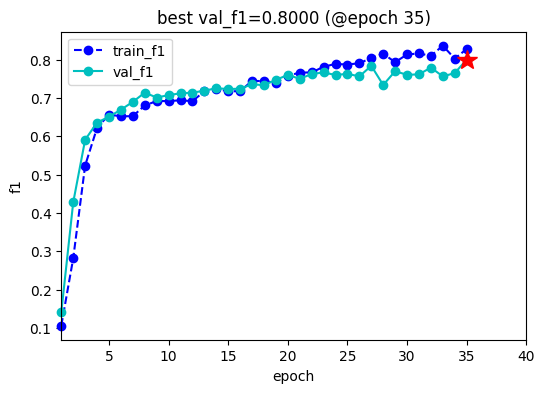

In [13]:
keras_model.fit(
    train_data=dl_train,
    val_data=dl_val,
    ckpt_path=ckpt_path,
    epochs=200,
    patience=10,
    monitor="val_f1",
    mode="max",
    plot=True,
    wandb=False,
    cpu=True,
)

In [ ]:
# Re-train
keras_model.fit(
    train_data=dl_full,
    val_data=dl_val,
    ckpt_path=ckpt_path,
    epochs=200,
    patience=10,
    mode="max",
    plot=True,
    wandb=False,
    cpu=True,
)

In [ ]:
from tqdm import tqdm
# Load model and predict
keras_model.load_ckpt(ckpt_path)
net = keras_model.net
preds = []
for batch in tqdm(dl_test):
    preds.append(net.predict(batch))
yhat_list = [yd.argmax(dim=-1).tolist() for yd in preds]
yhat = []
for yd in yhat_list:
    yhat.extend(yd)

In [ ]:
msisdn = validation_data['msisdn']
output_path = f'/home/hwxu/Projects/Competition/Telecom/Output/submissions/ftt-pred-{dataset_version}_{datetime.now()}.csv'
result = pd.DataFrame({'msisdn': msisdn, 'is_sa': yhat})
result.to_csv(output_path, index=False)